In [348]:
import os
import re
import numpy as np
import pandas as pd
import pickle as pkl
from metallum import Band, Album, Song

import nltk
from nltk.corpus import stopwords
languages = ['english', 'german', 'french', 'finnish', 'swedish', 'norwegian', 'danish', 'russian']
stop_words = set()
for language in languages:
    stop_words.update(set(stopwords.words(language)))
english_vocab = set(w.lower() for w in nltk.corpus.words.words())

import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier

from imblearn.over_sampling import RandomOverSampler

In [3]:
LYRICS_DIR = 'lyrics/'
BANDS_DIR = 'bands/'

In [69]:
band_filenames = [f for f in os.listdir(BANDS_DIR) if '.pkl' in f]
bands = [pkl.load(open(os.path.join(BANDS_DIR, f), 'rb')) for f in band_filenames]
band_genres = {b.name.lower(): b.genres for b in bands}

In [303]:
lyrics_filenames = [f for f in os.listdir(LYRICS_DIR) if '.pkl' in f]
lyrics = {filename.replace('.pkl', ''): pkl.load(open(os.path.join(LYRICS_DIR, filename), 'rb')) for filename in lyrics_filenames}
corpus = []
band_names = []
song_names = []
vocabulary = set()
genres = []
for band, band_lyrics in lyrics.items():
    if band in band_genres.keys():
        for album, album_lyrics in band_lyrics.items():
            for song, song_lyrics in album_lyrics.items():
                words = []
                for line in song_lyrics:
                    for w in line.split():
                        s = re.search("(\w+)|(\w+([-'])(\w+)?[']?(\w+))", w.lower())
                        if s:
                            w = s.group()
                            if True: #w in english_vocab and w not in stop_words:
                                words.append(w)
                song_name = []
                for w in song.split():
                    s = re.search("(\w+)|(\w+([-'])(\w+)?[']?(\w+))", re.sub('\d+\.', '', w).lower())
                    if s:
                        song_name.append(s.group())
                song_name = ' '.join(song_name)
                document = ' '.join(words)
                if len(document) > 0:
                    corpus.append(document)
                    band_names.append(band)
                    song_names.append(song_name)
                    vocabulary.update(set(words))
                    genres.append(band_genres[band])
print("vocabulary size: {}".format(len(vocabulary)))

vocabulary size: 171518


# Features dataframe

In [404]:
df_rows = [
    {'band': band_names[i], 'song': song_names[i], 'lyrics': corpus[i], 'genres': genres[i]} for i in range(len(corpus))
]
df = pd.DataFrame(df_rows, columns=['band', 'song', 'lyrics', 'genres'])
df = df.drop_duplicates(subset=['band', 'song'])
df.head()

,band,song,lyrics,genres
0,defiance,the fault,danger lingers in the air tonight don feel rig...,[thrash]
1,defiance,death machine,take a look into the future see a time that wi...,[thrash]
2,defiance,product of society,lost mind looking for something to fill that e...,[thrash]
3,defiance,forgotten,forgotten men who fought for shit went through...,[thrash]
4,defiance,lock jaw,have you ever felt a puncture thru the skin fr...,[thrash]


In [405]:
song_lengths = df['lyrics'].apply(lambda x: len(x.split()))
print(round(song_lengths.mean()), round(song_lengths.std()), song_lengths.min(), song_lengths.max())

160 85 1 1598


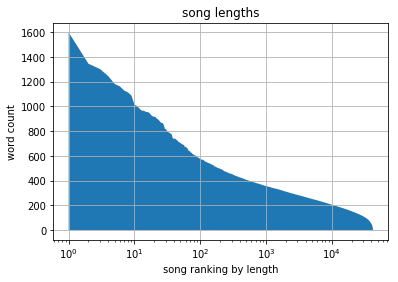

In [433]:
plt.fill_between(range(1, df.shape[0] + 1), 0, song_lengths.sort_values()[::-1].reset_index(drop=True))
plt.title("song lengths")
plt.xlabel('song ranking by length')
plt.ylabel('word count')
plt.xscale('log')
plt.grid(axis='both')
plt.show()

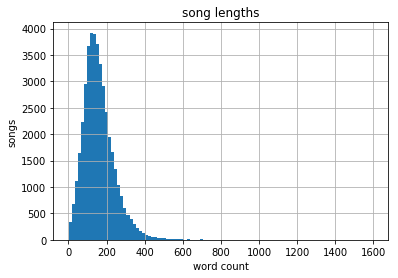

In [435]:
song_lengths.hist(bins=100)
plt.title("song lengths")
plt.xlabel('word count')
plt.ylabel('songs')
plt.show()

# Labels dataframe

In [436]:
unique_genres = sorted(set([x for lst in df['genres'].tolist() for x in lst]))
df_genres = pd.DataFrame(index=df.index, columns=unique_genres)
for genre in unique_genres:
    df_genres[genre] = df['genres'].apply(lambda x: 1 if genre in x else 0)
top_genres = df_genres.columns[df_genres.mean(axis=0) > 0.1]
df_genres = df_genres[top_genres]
df_genres['other'] = (df_genres.sum(axis=1) == 0).astype(int)
df_genres.head()

,black,death,heavy,melodic,power,progressive,thrash,other
0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,1,0


In [437]:
df_genres.mean(axis=0)

black          0.228073
death          0.326872
heavy          0.161634
melodic        0.106877
power          0.164225
progressive    0.110551
thrash         0.192628
other          0.136034
dtype: float64

# Tokenization & oversampling

In [485]:
corpus_train, corpus_test, y_train, y_test = train_test_split(df['lyrics'].values, df_genres['death'].values, test_size=0.2)

In [486]:
maxlen = song_lengths.max()

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(corpus_train)

vocab_size = len(tokenizer.word_index) + 1

X_train = tokenizer.texts_to_sequences(corpus_train)
X_test = tokenizer.texts_to_sequences(corpus_test)

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(33968, 1598) (8492, 1598) (33968,) (8492,)


In [487]:
X_train, y_train = RandomOverSampler(random_state=0).fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape)

(45678, 1598) (45678,)


# Test with a simple Keras model

In [488]:
embedding_dim = 50

def create_model(input_dim=None, output_dim=None, input_length=maxlen):
    model = Sequential()
    model.add(layers.Embedding(input_dim=input_dim,
                               output_dim=output_dim,
                               input_length=input_length))
    model.add(layers.Flatten())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = KerasClassifier(create_model, input_dim=vocab_size, output_dim=embedding_dim, epochs=3, batch_size=128, verbose=True)

In [489]:
scores = cross_val_score(model, X_train, y_train, cv=3, scoring='balanced_accuracy')
print("CV score: {:.1f}% +/- {:.1f}%".format(scores.mean() * 100, scores.std() * 200))

Epoch 1/3
30452/30452 [==============================] - 43s 1ms/step - loss: 0.6880 - acc: 0.5829
Epoch 2/3
30452/30452 [==============================] - 39s 1ms/step - loss: 0.6801 - acc: 0.5868
Epoch 3/3
15226/15226 [==============================] - 4s 244us/step
Epoch 1/3
30452/30452 [==============================] - 42s 1ms/step - loss: 0.6961 - acc: 0.5823
Epoch 2/3
30452/30452 [==============================] - 38s 1ms/step - loss: 0.6814 - acc: 0.5860
Epoch 3/3
15226/15226 [==============================] - 4s 251us/step
Epoch 1/3
30452/30452 [==============================] - 43s 1ms/step - loss: 0.5795 - acc: 0.6970
Epoch 2/3
30452/30452 [==============================] - 38s 1ms/step - loss: 0.5060 - acc: 0.7611
Epoch 3/3
15226/15226 [==============================] - 4s 251us/step
CV score: 58.4% +/- 23.8%


In [484]:
model.fit(X_train, y_train, class_weight=class_weight)
y_pred = model.predict(X_test)
print(balanced_accuracy_score(y_test, y_pred))

Epoch 1/1
8492/8492 [==============================] - 3s 334us/step
0.6079665363619577


### With global max pooling instead of flattening

In [280]:
embedding_dim = 50

def create_model(input_dim=None, output_dim=None, input_length=maxlen):
    model = Sequential()
    model.add(layers.Embedding(input_dim=input_dim,
                               output_dim=output_dim,
                               input_length=input_length))
    model.add(layers.GlobalMaxPool1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = KerasClassifier(create_model, input_dim=vocab_size, output_dim=embedding_dim, epochs=5, batch_size=10, verbose=False)

In [281]:
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='balanced_accuracy')
print("CV score: {:.1f}% +/- {:.1f}%".format(scores.mean() * 100, scores.std() * 200))

CV score: 87.3% +/- 9.4%


In [297]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(balanced_accuracy_score(y_test, y_pred))

0.5


### Convolutional neural network

In [284]:
embedding_dim = 50

def create_model(input_dim=None, output_dim=None, input_length=maxlen):
    model = Sequential()
    model.add(layers.Embedding(input_dim=input_dim,
                               output_dim=output_dim,
                               input_length=input_length))
    model.add(layers.Conv1D(128, 5, activation='relu'))
    model.add(layers.GlobalMaxPool1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = KerasClassifier(create_model, input_dim=vocab_size, output_dim=embedding_dim, epochs=5, batch_size=10, verbose=False)

In [298]:
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='balanced_accuracy')
print("CV score: {:.1f}% +/- {:.1f}%".format(scores.mean() * 100, scores.std() * 200))

CV score: 50.0% +/- 0.0%


In [297]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(balanced_accuracy_score(y_test, y_pred))

0.5
